In [1]:
from time import process_time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rebound
import reboundx
%matplotlib inline

In [2]:
Degree_To_Rad = np.pi/180.
AU_To_Meter = 1.496e11

m_Sun = 1.99e30 # solar mass in [kg]
R_Sun = 6.957e8 # solar radius in [m]
m_J = 1.898e27 # Jupiter mass in [kg]
R_J = 7.1492e7 # Jupiter radius in [m]
a_J = 7.78479e8 # Jupiter semi-major axis in [m]

k1 = 0.2 # m_star/m_Sun
m_Star = k1 * m_Sun
R_Star = k1**(1/3) * R_Sun
R_sub = (k1**2) * 4 * R_Sun

k2 = 1 # m_planet/m_Jupiter
m_Planet = k2 * m_J
R_Planet = k2**(1/3) * R_J

k_ap = 10
a_Planet = k_ap * R_Star

In [4]:
sim = rebound.Simulation()
sim.integrator = "ias15"
sim.G = 6.674e-11 # SI units
sim.dt = 1.e2 # Initial timestep in sec.
sim.N_active = 2 # Make it so dust particles don't interact with one another gravitationally

sim.add(m = m_Star, r = R_sub, hash = "Star")
sim.add(m = m_Planet, a = a_Planet, e = 0, r = R_Planet, hash = "Planet")
sim.move_to_com()

ps = sim.particles

sim.status()

---------------------------------
REBOUND version:     	3.17.3
REBOUND built on:    	Jun 26 2021 14:35:07
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	100.000000
---------------------------------
<rebound.particle.Particle object at 0x7f82b8cb3040, m=5.97e+29 x=-14759526.787539277 y=0.0 z=0.0 vx=0.0 vy=-293.594782706861 vz=0.0>
<rebound.particle.Particle object at 0x7f82b8cb30c0, m=1.898e+27 x=4642485506.9341135 y=0.0 z=0.0 vx=0.0 vy=92347.77938672078 vz=0.0>
---------------------------------


collision function setup
--

In [5]:
hash_Star = str(ps['Star'].hash)
hash_Planet = str(ps['Planet'].hash)

ps_sub = []
ps_pl = []

                  
def collision_function(sim_pointer, collision):
    simcontps = sim_pointer.contents.particles # get simulation object from pointer
    hash_p1 = str(simcontps[collision.p1].hash)
    hash_p2 = str(simcontps[collision.p2].hash)
    
    # p1 not dust              
    if hash_p1 == hash_Star:
        ps_sub.append(hash_p2)
        print ('Sublimation:', hash_p2, 'at %.5f'%(sim.t/yr), '[yr]')
        j = 2 # remove p2 (dust)
                 
    elif hash_p1 == hash_Planet:
        ps_pl.append(hash_p2)
        print ('Hit the Planet:', hash_p2, 'at %.5f'%(sim.t/yr), '[yr]')
        j = 2 # remove p2 (dust)
                  
    # p1 is dust  
    else:
        if hash_p2 == hash_Star:
            ps_sub.append(hash_p1)
            print ('Sublimation:', hash_p1, 'at %.5f'%(sim.t/yr), '[yr]')
            j = 1 # remove p1 (dust)
        else:
            ps_pl.append(hash_p1)
            print ('Hit the Planet:', hash_p1, 'at %.5f'%(sim.t/yr), '[yr]')
            j = 1 # remove p1 (dust)

    return j                            


sim.collision = "direct"
sim.collision_resolve = collision_function

set up reboundx and radiation force & PR-drag force
--

In [6]:
rebx = reboundx.Extras(sim)
rf = rebx.load_force("radiation_forces")
rebx.add_force(rf)
rf.params["c"] = 3.e8


In [7]:
ps["Star"].params["radiation_source"] = 1 # set 'Star' to be the source of radiation

In [8]:
a = 3*a_Planet
e = 0
inc = 10 # [degree]

# amin = 100.*AU
# awidth = 20.*AU
# incmax = np.arcsin(0.1)

beta = 0.01
Ndust = 100

import random
seed = 3
random.seed(seed)

for i in range(2, Ndust+2):
#     a = amin + awidth*random.random() # Semimajor axis
    pomega = 2*np.pi*random.random()  # Longitude of pericenter
    f = 2*np.pi*random.random()       # True anomaly
    Omega = 2*np.pi*random.random()   # Longitude of node
#     inc = incmax*random.random()      # Inclination
    sim.add(a=a, e=e, inc=inc*Degree_To_Rad, Omega=Omega, pomega=pomega, f=f, hash=i)
    ps[i].params["beta"] = beta

In [9]:
xs = [ps[i].x for i in range(sim.N)]
ys = [ps[i].y for i in range(sim.N)]
zs = [ps[i].z for i in range(sim.N)]

Text(0.5, 1.0, 'Edge-on view')

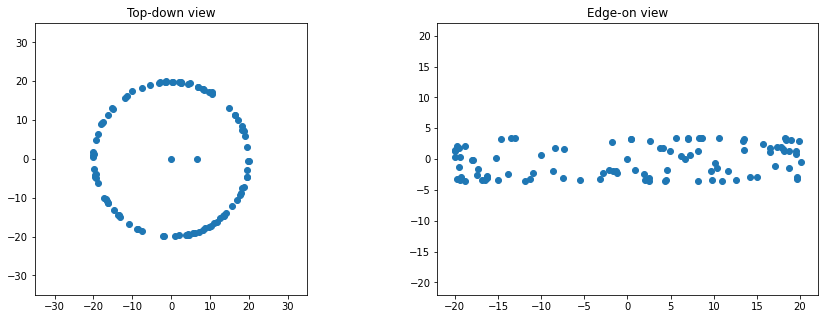

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(np.array(xs)/R_Sun, np.array(ys)/R_Sun)
ax1.set_xlim([-35, 35])
ax1.set_ylim([-35, 35])
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
ax2.scatter(np.array(xs)/R_Sun, np.array(zs)/R_Sun)
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')

Start Integration
--

In [11]:
# pick out dusts that have been ejected out

# PE + KE wrt Star
def get_E(sim, ps_i):
    rstar = np.array(ps['Star'].xyz)
    r = np.array(ps_i.xyz)
    v = np.array(ps_i.vxyz)
    
    KE = 0.5 * v@v # test particle kinetic energy
    mu = sim.G * ps['Star'].m
    r_ds = r - rstar
    PE = -mu/np.sqrt(r_ds@r_ds) # test particle potential energy
    
    E = KE + PE
    
    return E

In [12]:
start = process_time()

yr = 365*24*3600 # s

Noutput = 100
times = np.linspace(0, 1e4*yr, Noutput)

x0 = np.zeros(Noutput)

ps_ej = []

for i, time in enumerate(times):
    sim.integrate(time)
    x0[i] = ps[0].x
    
    # ejection judgement
    E_ps_array = []
    for j in range(2, sim.N):
        E_ps_array.append(get_E(sim, ps[j]))
    
    index_ej = np.where(np.array(E_ps_array)>0)[0] + 2
    
    l = 0 # count of dusts already removed in this round
    for k in range(len(index_ej)):
        ps_ej.append(str(ps[int(index_ej[k])-l].hash))
        print ('Ejection:', str(ps[int(index_ej[k])-l].hash), 'at %.5f'%(sim.t/yr), '[yr]')
        sim.remove(int(index_ej[k])-l)
        l += 1
            
    if sim.N == 2:
        print ('No dusts left. Finish integration. :)')
        break    


end = process_time()
print("Running time: %s Seconds"%(end-start))  

Hit the Planet: c_uint(100) at 967.45515 [yr]
Hit the Planet: c_uint(33) at 1007.64052 [yr]
Hit the Planet: c_uint(50) at 1014.08485 [yr]
Hit the Planet: c_uint(21) at 1082.36509 [yr]
Hit the Planet: c_uint(6) at 1098.21851 [yr]
Sublimation: c_uint(20) at 1103.53592 [yr]
Ejection: c_uint(68) at 1111.11111 [yr]
Ejection: c_uint(74) at 1111.11111 [yr]
Hit the Planet: c_uint(75) at 1339.40669 [yr]
Hit the Planet: c_uint(23) at 1348.40079 [yr]
Hit the Planet: c_uint(32) at 1363.57242 [yr]
Hit the Planet: c_uint(91) at 1367.28813 [yr]
Hit the Planet: c_uint(24) at 1373.66685 [yr]
Hit the Planet: c_uint(39) at 1379.89967 [yr]
Hit the Planet: c_uint(95) at 1390.07415 [yr]
Ejection: c_uint(5) at 1414.14141 [yr]
Ejection: c_uint(12) at 1414.14141 [yr]
Ejection: c_uint(27) at 1414.14141 [yr]
Ejection: c_uint(40) at 1414.14141 [yr]
Ejection: c_uint(45) at 1414.14141 [yr]
Ejection: c_uint(59) at 1414.14141 [yr]
Ejection: c_uint(18) at 1515.15152 [yr]
Ejection: c_uint(57) at 1515.15152 [yr]
Ejectio

In [13]:
print("Particles in the simulation at t=%5.1f : %d"%(sim.t/yr, sim.N))

Particles in the simulation at t=7272.7 : 2


In [14]:
xs_f = [ps[i].x for i in range(sim.N)]
ys_f = [ps[i].y for i in range(sim.N)]
zs_f = [ps[i].z for i in range(sim.N)]

Text(0.5, 1.0, 'Edge-on view')

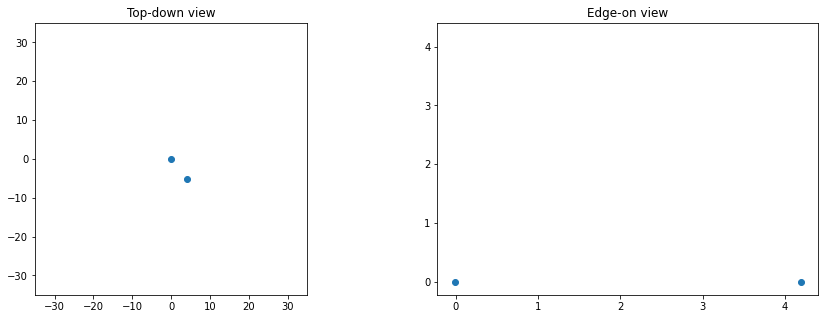

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(np.array(xs_f)/R_Sun, np.array(ys_f)/R_Sun)
ax1.set_xlim([-35, 35])
ax1.set_ylim([-35, 35])
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
ax2.scatter(np.array(xs_f)/R_Sun, np.array(zs_f)/R_Sun)
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')

fraction of outcomes
--

In [16]:
N_sub = len(ps_sub)
N_pl = len(ps_pl)
N_ej = len(ps_ej)
N_lf = Ndust - N_sub - N_pl - N_ej

print('Number of dusts entering the Star sublimation zone: %d'%(N_sub))
print('Number of dusts hitting the Planet: %d'%(N_pl))
print('Number of dusts ejected out: %d'%(N_ej))
print('Number of dusts remaining in the system: %d'%(N_lf))

Number of dusts entering the Star sublimation zone: 4
Number of dusts hitting the Planet: 41
Number of dusts ejected out: 55
Number of dusts remaining in the system: 0


In [17]:
f_sub = N_sub/Ndust
f_pl = N_pl/Ndust
f_ej = N_ej/Ndust
f_lf = N_lf/Ndust

In [18]:
para = np.array([[k1, k2, k_ap, beta, inc, f_sub, f_pl, f_ej, f_lf]])
paralabels = ["m_Star/m_Sun", "m_Planet/m_J", "a_p/R_Star", "beta", "inc_d", "f_sub", "f_pl", "f_ej", "f_lf"]
df_para = pd.DataFrame(para, columns = paralabels)
df_para
# df_para.to_csv('./result0.csv', header=True, index=False)

,m_Star/m_Sun,m_Planet/m_J,a_p/R_Star,beta,inc_d,f_sub,f_pl,f_ej,f_lf
0,0.3,1.0,10.0,0.01,10.0,0.04,0.41,0.55,0.0


In [19]:
para

array([[ 0.3 ,  1.  , 10.  ,  0.01, 10.  ,  0.04,  0.41,  0.55,  0.  ]])

In [ ]:
#     for j in range(2, sim.N):    
#         if j == sim.N: break
#         E_ps = get_E(sim, ps[j])
#         if E_ps > 0:
#             ps_ej.append(str(ps[j].hash))
#             print ('Ejection:', str(ps[j].hash), 'at %.5f'%(sim.t/yr), '[yr]')
#             sim.remove(hash = ps[j].hash)